In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# 데이터 준비
# 삼각함수 파형으로 데이터를 임의로 설정하였습니다.
data_size = 100000
time_steps = np.linspace(0, 100, data_size, dtype=np.float16)

sensor_cnt = 3

data_sensor01 = np.sin(time_steps)
data_sensor02 = np.cos(time_steps)
# 탄젠트 함수인데 (-2,2) 까지 경계선을 정한 넘파이 배열
data_sensor03 = np.clip(np.tan(time_steps), -2, 2)

data_light = (data_sensor01 + data_sensor02 + data_sensor03)

# Tensorflow Tensor로 변환하기 위한 전처리
ndata_s01 = data_sensor01.reshape(data_size, 1)
ndata_s02 = data_sensor02.reshape(data_size, 1)

ndata_s03 = data_sensor03.reshape(data_size, 1)

ndata_light = data_light.reshape(data_size,1)
mdata = np.concatenate((ndata_s01, ndata_s02, ndata_s03, ndata_light), axis=1)

In [3]:
# sequence data loader 정의
def load_data(raw, look_back):
    data_raw = raw
    data = []

    # create all possible sequences of length look_back
    for index in range(len(data_raw) - look_back):
        data.append(data_raw[index: index + look_back])

    data = np.array(data);
    test_set_size = int(np.round(0.1*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);

    x_train = data[:train_set_size,:,:sensor_cnt]
    y_train = data[:train_set_size,-1,sensor_cnt:]

    x_test = data[train_set_size:,:, :sensor_cnt]
    y_test = data[train_set_size:,-1,sensor_cnt:]

    return [x_train, y_train, x_test, y_test]

# look back 의 의미 : 특정 크기의 단위만큼 이전 값을 고려한다
# 단위는 초(seconds) 가 될 것이라 예상

In [4]:
sequence_size = 10 # choose sequence length
x_train, y_train, x_test, y_test = load_data(mdata, sequence_size)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (89991, 10, 3)
y_train.shape =  (89991, 1)
x_test.shape =  (9999, 10, 3)
y_test.shape =  (9999, 1)


In [5]:
# numpy to tensor
x_train = tf.convert_to_tensor(x_train)
x_test = tf.convert_to_tensor(x_test)
y_train = tf.convert_to_tensor(y_train)
y_test = tf.convert_to_tensor(y_test)

In [6]:
# LSTM 모델 정의
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.models import Sequential
model = Sequential()
model.add(LSTM(64,
               input_shape = (sequence_size, sensor_cnt),
              return_sequences=True))
model.add(LSTM(64))
model.add(Dense(1))

In [7]:
#모델 컴파일
model.compile(optimizer = 'adam',
              loss='mean_squared_error',
             )

In [8]:
# 모델 요약
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            17408     
                                                                 
 lstm_1 (LSTM)               (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 50497 (197.25 KB)
Trainable params: 50497 (197.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [9]:
#모델 학습
history = model.fit(x_train, y_train, 
                    epochs = 10, 
                    batch_size = 32,
                    validation_split=0.18)

Epoch 1/10
2306/2306 [==============================] - 13s 5ms/step - loss: 0.0159 - val_loss: 7.5596e-04
Epoch 2/10
2306/2306 [==============================] - 11s 5ms/step - loss: 3.5854e-04 - val_loss: 5.0151e-04
Epoch 3/10
2306/2306 [==============================] - 11s 5ms/step - loss: 2.7826e-04 - val_loss: 6.6016e-04
Epoch 4/10
2306/2306 [==============================] - 11s 5ms/step - loss: 2.5483e-04 - val_loss: 2.8865e-04
Epoch 5/10
2306/2306 [==============================] - 11s 5ms/step - loss: 1.7701e-04 - val_loss: 8.3124e-05
Epoch 6/10
2306/2306 [==============================] - 11s 5ms/step - loss: 9.6758e-05 - val_loss: 3.0964e-05
Epoch 7/10
2306/2306 [==============================] - 11s 5ms/step - loss: 1.1884e-04 - val_loss: 2.3418e-05
Epoch 8/10
2306/2306 [==============================] - 11s 5ms/step - loss: 6.0251e-05 - val_loss: 1.3454e-04
Epoch 9/10
2306/2306 [==============================] - 11s 5ms/step - loss: 7.3886e-05 - val_loss: 8.9462e-06
Epoch

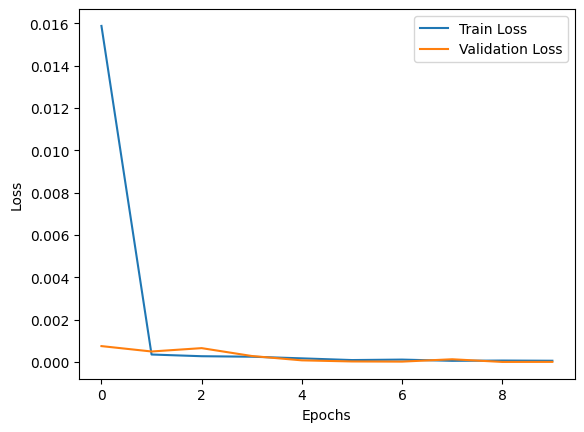

In [10]:
import matplotlib.pyplot as plt

# 학습 과정 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [11]:
# 모델 평가
results = model.evaluate(x_test, y_test)
print(f'Test loss : {results:.3%}')

313/313 [==============================] - 1s 2ms/step - loss: 8.0901e-06
Test loss : 0.001%


313/313 [==============================] - 1s 2ms/step


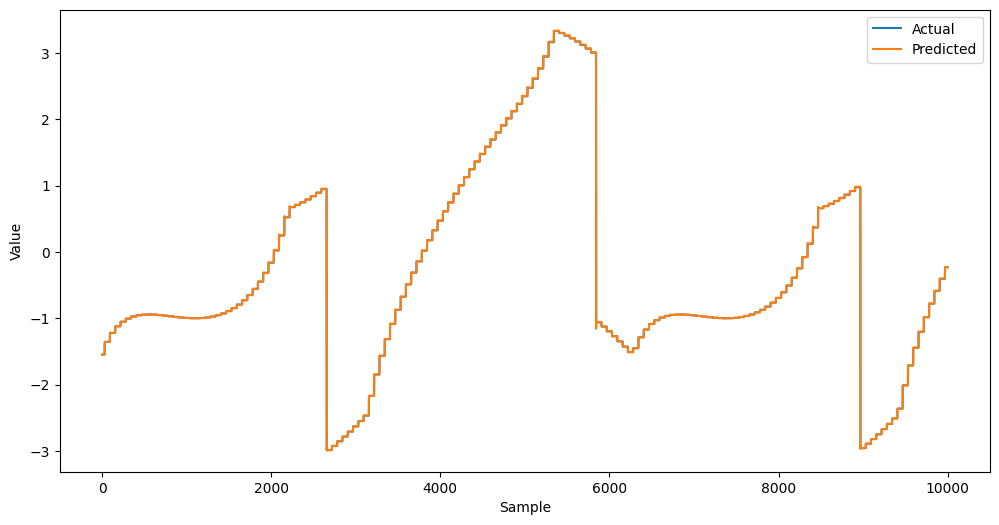

In [12]:
# 예측
y_pred = model.predict(x_test)

# 예측 결과 시각화
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()

In [13]:
# 현재 학습한 모델 저장
# 모델 전체 정보를 저장
# 텐서플로에서는 하나의 디렉토리에 저장함
model.save("LSTM_231031")

INFO:tensorflow:Assets written to: LSTM_231031/assets


INFO:tensorflow:Assets written to: LSTM_231031/assets


In [16]:
test_input = x_test[-1]
print(test_input)

tf.Tensor(
[[-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]
 [-0.5063  0.8623 -0.5874]], shape=(10, 3), dtype=float16)


In [22]:
test_input = tf.reshape(test_input, [1,10,3])
test_input

<tf.Tensor: shape=(1, 10, 3), dtype=float16, numpy=
array([[[-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874],
        [-0.5063,  0.8623, -0.5874]]], dtype=float16)>

In [28]:
test_ans = y_test[-1]
test_pre = model.predict(test_input)
print(test_ans)
print(test_pre)

1/1 [==============================] - 0s 11ms/step
tf.Tensor([-0.2314], shape=(1,), dtype=float16)
[[-0.2308701]]


### 하이퍼 파라미터 튜닝

- 모델의 성능을 개선하기 위해 변수들을 조절함
- 모델은 추론에 있어 정확성을 지니면서, 동시에 과적합을 방지해야 함
- 현재 프로세스에서 튜닝할 수 있는 파라미터들
    - **sqeuence_size (= look_back)**
    - **LSTM layer의 hidden_size**
    - batch_size
    - learning_rate
    - 활성화 함수
    - 최적화 함수
    - 계층의 크기(혹은 깊이) 등...